# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [20]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [21]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [22]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 10093 / 11441 MB available


In [36]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}
__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];
}

//NOTE: we need to implement the function matrixVectorKernel
//c = A*b
__global__ void matrixVectorKernel(float* c, float* a, float* b, int a_rows, int a_cols) {
    //NOTE: write for loop that computes the vector-vector inner product
    //of row j of A by our vector b, and store the result in
    //c[j]
    
    //i index is always zero!
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    float sum = 0.0f;
    
    for (int i = 0; i<a_cols; i++) {
        unsigned int k = j*a_cols + i;
        sum += a[k] * b[i];
        
        //c[j] += a[k] * b[i]; //c is in global memory, so far far away. Not good communicating
    }
    
    //c[j] = sum;
   c[j] = j;
}


"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

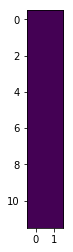

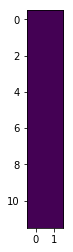

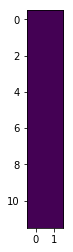

In [37]:
testing_variable = np.empty((12, 2))
plt.figure()
plt.imshow(testing_variable)

testing_variable = np.zeros((12, 2))
plt.figure()
plt.imshow(testing_variable)

testing_variable = np.ones((12, 2))
plt.figure()
plt.imshow(testing_variable)

In [39]:
#Size of our test
test_size = (16, 24)

#Create test input / output data
a = np.random.random((4,3)).astype(np.float32)
b = np.random.random((3,1)).astype(np.float32)
c = np.empty((4,1), dtype = np.float32)

fig = plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(a)
plt.show()

plt.subplot(1,3,2)
plt.imshow(b)
plt.show()

plt.subplot(1,3,3)
plt.imshow(c)
plt.show()

SyntaxError: can't assign to function call (<ipython-input-39-edeb75b4ca1e>, line 7)

In [38]:
print(a.shape)

(4, 3)


In [ ]:
#Upload data to the device
#NOTE: we need to make sure that a=(rows,cols) 
#and that b=(cols in a,1) (column vector)
#and c = (a_rows, 1)
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [ ]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [ ]:
print(a.shape)
print(b.shape)
print(c.shape)

In [ ]:
#a.shape = [rows, columns] => [y, x]
domain_size = (a.shape[1], a.shape[0]) #Now domain size = [x, y]
#NOTE: we need to change this in order so that grid*block is: x = 1, y = number of rows in A
block_size = (1, 1, 1) #These need to be [x, y, z]
#grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)
grid_size = (1, c.shape[0], 1)

print("Domain_size is " + str(domain_size))
print("Block_size is " + str(block_size))
print("Grid_size is " + str(grid_size))

In [ ]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [25]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.82425785 1.3063028  1.1934574  0.6712711  1.6580148  1.7739623
  0.92673373 0.7710205  0.863724   0.9188934  1.2666498  1.0538803
  1.2713938  0.43981427 0.58323795 1.0399183  1.6472576  0.654047
  0.9283961  1.2021201  1.1786699  1.0241377  1.0449497  1.5436366 ]
 [0.43262976 1.4579455  0.7136212  0.5171683  0.60397404 1.2522228
  0.9442873  0.7507281  0.8162148  1.298001   1.7912476  1.3927608
  1.1585574  0.50003743 1.2230288  1.083072   1.5864518  0.4845649
  0.32669914 1.3327875  0.80417526 0.633654   1.548624   1.8194683 ]
 [1.1171598  0.13638063 1.1322105  0.7850393  1.004755   1.4502498
  0.5649321  1.182189   1.0362024  1.9429855  0.61295366 1.2128248
  0.8597044  1.3219403  0.84680563 1.4927504  1.7898815  1.3415761
  0.89243925 0.5061937  0.6713599  1.5148919  1.0924857  1.3566332 ]
 [0.9094578  1.8346775  1.626907   0.2959229  1.1759131  0.41467625
  0.82893574 0.80897045 1.2451855  0.7246984  0.5290614  0.90544385
  1.4953939  1.1379282  0.34494752 0.6803453  0.

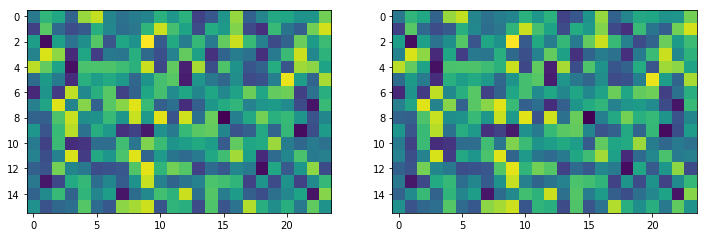

In [26]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)